# A to Z Model

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

In [25]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Paths
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

In [26]:

# Number of classes (A-Z = 26)
NUM_CLASSES = 36

# Load dataset
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset, 
    y_dataset,
    train_size=0.75,
    random_state=RANDOM_SEED
)


In [27]:
# Define correct labels for display and model training
def get_label_name(index):
    if 0 <= index <= 25:
        return chr(index + 65)  # A-Z
    elif 26 <= index <= 35:
        return str(index - 26)  # 0-9
    return "Unknown"

# Update NUM_CLASSES to include digits
NUM_CLASSES = 36  # A-Z (26) + 0-9 (10)

# Create proper target_names for classification report
target_names = []
for i in range(NUM_CLASSES):
    target_names.append(get_label_name(i))

# Update model to have 36 output classes
model = tf.keras.Sequential([
    tf.keras.layers.Input((84,)),  # 42 features * 2 hands
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(36, activation='softmax')  # 36 classes (A-Z + 0-9)
])

# # Create model
# model = tf.keras.Sequential([
#     tf.keras.layers.Input((84,)),  # 42 features * 2 hands
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed=RANDOM_SEED)),
#     tf.keras.layers.Dropout(0.3, seed=RANDOM_SEED),
#     tf.keras.layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed=RANDOM_SEED)),
#     tf.keras.layers.Dropout(0.3, seed=RANDOM_SEED),
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(seed=RANDOM_SEED))
# ])

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



In [28]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, 
    verbose=1, 
    save_weights_only=False
)
es_callback = tf.keras.callbacks.EarlyStopping(
    patience=20, 
    verbose=1, 
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)


In [29]:

# Train model
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[cp_callback, es_callback, reduce_lr]
)

Epoch 1/200
368/380 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2719 - loss: 2.6228
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2776 - loss: 2.5987 - val_accuracy: 0.8963 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 2/200
348/380 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7253 - loss: 0.8090
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7289 - loss: 0.7988 - val_accuracy: 0.9503 - val_loss: 0.2787 - learning_rate: 0.0010
Epoch 3/200
338/380 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8519 - loss: 0.4380
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8538 - loss: 0.4327 - val_accuracy: 0.9859 - val_loss: 0.1287 - learning_rate: 0.0010
Epoch 4/200
342/380 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9043 - loss: 0.296

KeyboardInterrupt: 

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 3.3940e-04  

Validation accuracy: 1.0000
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step


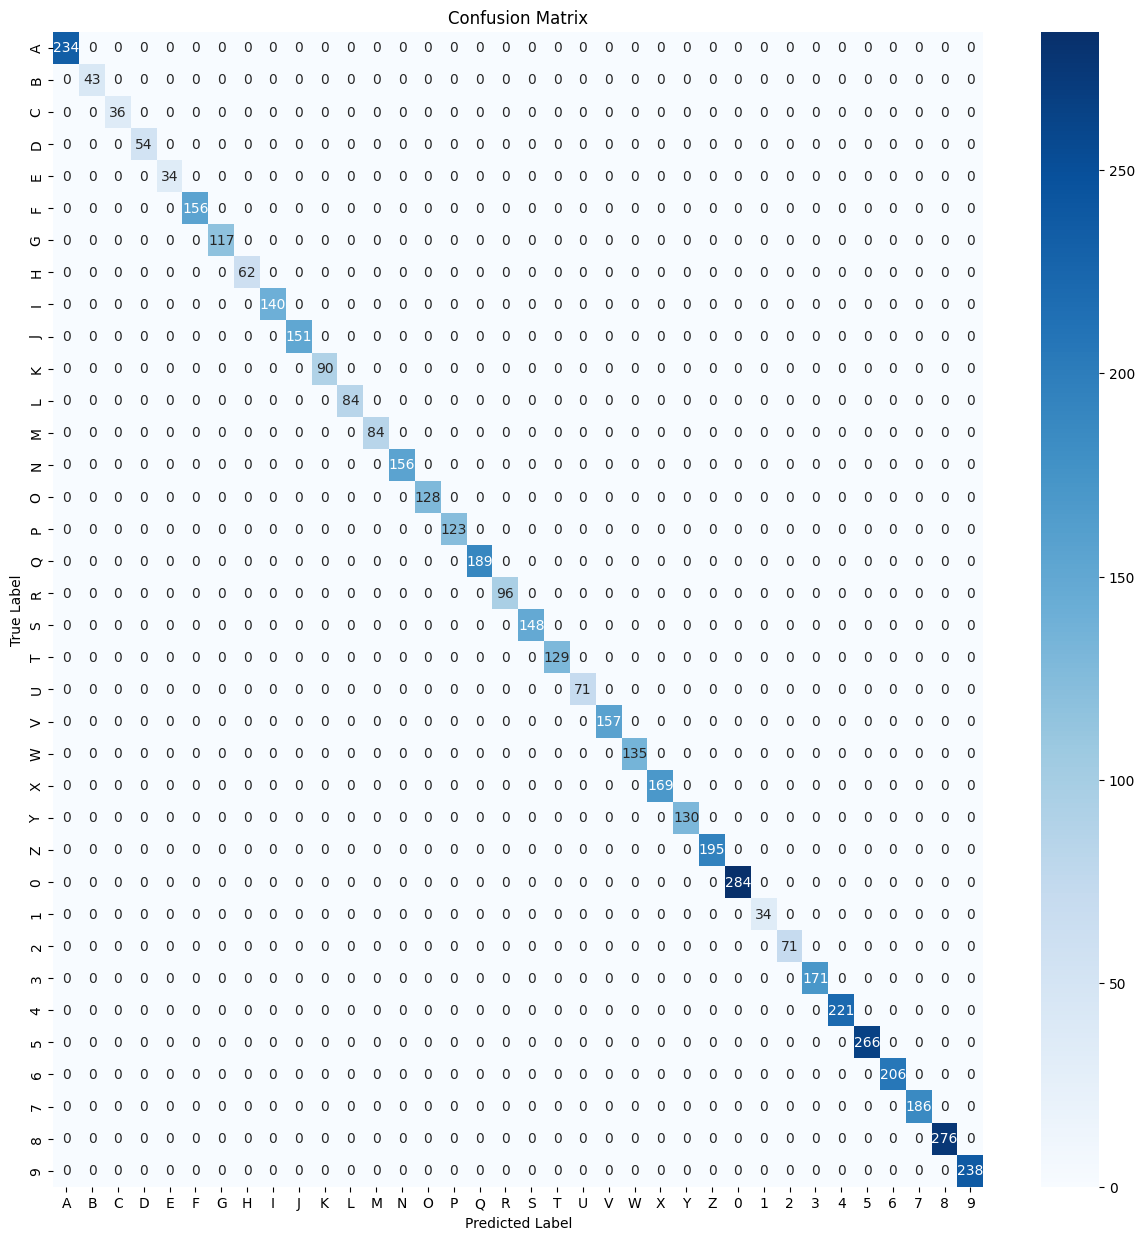

In [40]:
# Evaluate model
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=32)
print(f"\nValidation accuracy: {val_acc:.4f}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Prepare labels: digits 0-9 followed by letters A-Z
labels = [chr(i + 65) for i in range(26)] + [str(i) for i in range(10)] 

# Plot confusion matrix
plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       234
           B       1.00      1.00      1.00        43
           C       1.00      1.00      1.00        36
           D       1.00      1.00      1.00        54
           E       1.00      1.00      1.00        34
           F       1.00      1.00      1.00       156
           G       1.00      1.00      1.00       117
           H       1.00      1.00      1.00        62
           I       1.00      1.00      1.00       140
           J       1.00      1.00      1.00       151
           K       1.00      1.00      1.00        90
           L       1.00      1.00      1.00        84
           M       1.00      1.00      1.00        84
           N       1.00      1.00      1.00       156
           O       1.00      1.00      1.00       128
           P       1.00      1.00      1.00       123
           Q       1.00      1.00      1.00       189
   

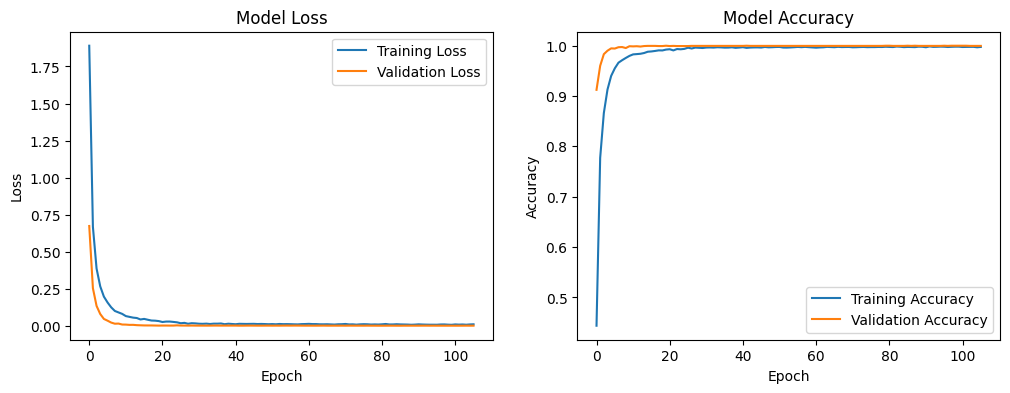

In [41]:

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, 
                          target_names=[chr(i + 65) for i in range(NUM_CLASSES)]))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
# Save model as TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

print("\nTraining and evaluation complete. Model saved as TFLite.")

INFO:tensorflow:Assets written to: C:\Users\swapn\AppData\Local\Temp\tmpxbncmh04\assets


INFO:tensorflow:Assets written to: C:\Users\swapn\AppData\Local\Temp\tmpxbncmh04\assets


Saved artifact at 'C:\Users\swapn\AppData\Local\Temp\tmpxbncmh04'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 84), dtype=tf.float32, name='keras_tensor_27')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  2250607681872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2250607687440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2250607681488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2250607674192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2250607687824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2250607687632: TensorSpec(shape=(), dtype=tf.resource, name=None)

Training and evaluation complete. Model saved as TFLite.
